<a href="https://colab.research.google.com/github/sunilthakan/Human-activity-recognistion/blob/main/carniwal_wars.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install CatBoost

In [2]:
import warnings
warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression,SGDRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, BaggingRegressor, ExtraTreesRegressor, GradientBoostingRegressor
import xgboost as xgb
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [3]:
from google.colab import drive
from google.colab import files

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df_test = pd.read_csv(r'/content/drive/MyDrive/carniwal_wars/dataset/test.csv').reset_index(drop=True)
df_train = pd.read_csv(r"/content/drive/MyDrive/carniwal_wars/dataset/train.csv").reset_index(drop=True)

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6368 entries, 0 to 6367
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Product_id        6368 non-null   object 
 1   Stall_no          6363 non-null   float64
 2   instock_date      6368 non-null   object 
 3   Market_Category   6368 non-null   int64  
 4   Customer_name     6157 non-null   object 
 5   Loyalty_customer  6368 non-null   object 
 6   Product_Category  6368 non-null   object 
 7   Grade             6368 non-null   int64  
 8   Demand            6368 non-null   int64  
 9   Discount_avail    6330 non-null   float64
 10  charges_1         6170 non-null   float64
 11  charges_2 (%)     6163 non-null   float64
 12  Minimum_price     6330 non-null   float64
 13  Maximum_price     6025 non-null   float64
 14  Selling_Price     6327 non-null   float64
dtypes: float64(7), int64(3), object(5)
memory usage: 746.4+ KB


In [6]:
df_train.Discount_avail.value_counts()

0.0    5441
1.0     889
Name: Discount_avail, dtype: int64

In [7]:
df_train['Selling_Price'] = abs(df_train['Selling_Price'])

print(df_train.shape)
#df_train=df_train[df_train['Maximum_price']>=df_train['Minimum_price']]
#print(df_train.shape)

df_train['dis'] = df_train['Selling_Price'] - df_train['Minimum_price']

def retn(x):
    if (x<0):
        return (1)
    else:
        return (0)

df_train['dis'] = df_train['dis'].apply(retn)
df_train['Discount_avail'] = df_train['Discount_avail'].fillna(df_train['dis'])
df_train.drop(columns=['dis'],inplace=True)


df_train['charges_1'] = df_train['charges_1'].fillna(99)
df_train['charges_2 (%)'] = df_train['charges_2 (%)'].fillna(18)
df_train['Customer_name'] = df_train['Customer_name'].fillna('sunu')
df_test['charges_1'] = df_test['charges_1'].fillna(99)
df_test['charges_2 (%)'] = df_test['charges_2 (%)'].fillna(18)
df_test['Customer_name'] = df_test['Customer_name'].fillna('sunu')


df_train = df_train.set_index('Product_id')
df_test = df_test.set_index('Product_id')

df_train['Stall_no'].loc['NKCE6P3FFZHHTYSR']=1
df_train['Stall_no'].loc['NKCEAX7HMXEAZEFR']=44
df_train['Stall_no'].loc['NKCE3Y6EKYJEFUYV']=38
df_train['Stall_no'].loc['CRTECN2RRRSAH7JT']=11
df_train['Stall_no'].loc['CAGE68FGFNP5CSBD']=12
df_test['Stall_no'].loc['BRAECFAQXWGHUZDQ']=28

df_train['Year'] = pd.DatetimeIndex(df_train['instock_date']).year
df_train['Mon'] = pd.DatetimeIndex(df_train['instock_date']).month
df_train['date'] = pd.DatetimeIndex(df_train['instock_date']).day
df_train['day'] = pd.DatetimeIndex(df_train['instock_date']).dayofweek
df_train['hour'] = pd.DatetimeIndex(df_train['instock_date']).hour

df_test['Year'] = pd.DatetimeIndex(df_test['instock_date']).year
df_test['Mon'] = pd.DatetimeIndex(df_test['instock_date']).month
df_test['date'] = pd.DatetimeIndex(df_test['instock_date']).day
df_test['day'] = pd.DatetimeIndex(df_test['instock_date']).dayofweek
df_test['hour'] = pd.DatetimeIndex(df_test['instock_date']).hour

(6368, 15)


In [8]:
df_train = df_train.dropna(subset=['Selling_Price','Maximum_price'])
df = pd.concat([df_train,df_test],ignore_index=True)

#df['Minimum_price']=df['Minimum_price'].fillna(df['Minimum_price'].mean())

df['Minimum_price'] = df.groupby(['Product_Category','Grade','Market_Category','Discount_avail','Year','Mon'])['Minimum_price'].transform(lambda x: x.fillna(x.mean()))
df['Minimum_price'] = df.groupby(['Product_Category','Grade','Market_Category','Year','Mon'])['Minimum_price'].transform(lambda x: x.fillna(x.mean()))
df['Minimum_price'] = df.groupby(['Product_Category','Grade','Year','Mon'])['Minimum_price'].transform(lambda x: x.fillna(x.mean()))
df['Minimum_price'] = df.groupby(['Product_Category','Grade','Discount_avail'])['Minimum_price'].transform(lambda x: x.fillna(x.mean()))
df['Minimum_price'] = df.groupby(['Product_Category','Grade'])['Minimum_price'].transform(lambda x: x.fillna(x.mean()))


df['Maximum_price'] = df.groupby(['Product_Category','Grade','Market_Category','Discount_avail','Year','Mon'])['Maximum_price'].transform(lambda x: x.fillna(x.mean()))
df['Maximum_price'] = df.groupby(['Product_Category','Grade','Market_Category','Year','Mon'])['Maximum_price'].transform(lambda x: x.fillna(x.mean()))
df['Maximum_price'] = df.groupby(['Product_Category','Grade','Year','Mon'])['Maximum_price'].transform(lambda x: x.fillna(x.mean()))
df['Maximum_price'] = df.groupby(['Product_Category','Grade','Discount_avail'])['Maximum_price'].transform(lambda x: x.fillna(x.mean()))
df['Maximum_price'] = df.groupby(['Product_Category','Grade'])['Maximum_price'].transform(lambda x: x.fillna(x.mean()))
print(df_train.shape)

(5986, 19)


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9416 entries, 0 to 9415
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Stall_no          9416 non-null   float64
 1   instock_date      9416 non-null   object 
 2   Market_Category   9416 non-null   int64  
 3   Customer_name     9416 non-null   object 
 4   Loyalty_customer  9416 non-null   object 
 5   Product_Category  9416 non-null   object 
 6   Grade             9416 non-null   int64  
 7   Demand            9416 non-null   int64  
 8   Discount_avail    9416 non-null   float64
 9   charges_1         9416 non-null   float64
 10  charges_2 (%)     9416 non-null   float64
 11  Minimum_price     9416 non-null   float64
 12  Maximum_price     9416 non-null   float64
 13  Selling_Price     5986 non-null   float64
 14  Year              9416 non-null   int64  
 15  Mon               9416 non-null   int64  
 16  date              9416 non-null   int64  


In [10]:
df['instock_date'] = pd.DatetimeIndex(df['instock_date']).date

def calculate_rate(year,month):
  if((year ==2014)&(month<=10)):
    return('2014-10-31')
  elif(((year ==2015)&(month<=10))|(year ==2014)&(month>10)):
    return('2015-10-31')
  else:
    return('2016-10-31')

df["days_left"] = df[['Year','Mon']].apply(lambda x : calculate_rate(*x), axis=1)
df['days_left'] = pd.DatetimeIndex(df['days_left']).date
df['days_left'] = df['days_left'] - df['instock_date']
df['days_left']=df['days_left']/np.timedelta64(1,'D')

def calculate(Minimum_price,Maximum_price,Discount_avail):
  if(Discount_avail==0):
    avg = (Minimum_price+Maximum_price)/2
    return(avg)
  else:
    avg = (Minimum_price+Maximum_price)/10
    return(avg)

df["avg"] = df[['Minimum_price','Maximum_price','Discount_avail']].apply(lambda x : calculate(*x), axis=1)
df["avg1"] = (df['Minimum_price']+df['Maximum_price'])/2
df["sell"] = (df['Minimum_price']*0.3+df['Maximum_price']*0.7)

In [11]:
df['unit_price']  = df['avg']/df['Demand']
df['unit_price1']  = df['avg1']/df['Demand']
df['unit_price2']  = df['sell']/df['Demand']
df['unit_price3']  = df['Maximum_price']/df['Demand']
df['unit_price4']  = df['Minimum_price']/df['Demand']

In [12]:
df['crge']  = (df['avg']*df['charges_1'])/100
df['crge1']  = (df['avg1']*df['charges_1'])/100
df['crge2']  = (df['sell']*df['charges_1'])/100
df['crge3']  = (df['Minimum_price']*df['charges_1'])/100
df['crge4']  = (df['Maximum_price']*df['charges_1'])/100

df['crge11']  = (df['avg']*df['charges_2 (%)'])/100
df['crge12']  = (df['avg1']*df['charges_2 (%)'])/100
df['crge23']  = (df['sell']*df['charges_2 (%)'])/100
df['crge34']  = (df['Minimum_price']*df['charges_2 (%)'])/100
df['crge45']  = (df['Maximum_price']*df['charges_2 (%)'])/100

df['crge111']  = df['avg'] - (df['avg']*df['charges_1'])/100
df['crge112']  = df['avg1']- (df['avg1']*df['charges_1'])/100
df['crge222']  = df['sell'] - (df['sell']*df['charges_1'])/100
df['crge322']  = df['Minimum_price'] - (df['Minimum_price']*df['charges_1'])/100
df['crge422']  = df['Maximum_price'] -(df['Maximum_price']*df['charges_1'])/100

df['crge119']  = df['avg'] - (df['avg']*df['charges_2 (%)'])/100
df['crge129']  = df['avg1']-(df['avg1']*df['charges_2 (%)'])/100
df['crge239']  = df['sell'] -(df['sell']*df['charges_2 (%)'])/100
df['crge349']  = df['Minimum_price'] - (df['Minimum_price']*df['charges_2 (%)'])/100
df['crge459']  = df['Maximum_price'] - (df['Maximum_price']*df['charges_2 (%)'])/100

In [13]:
lst =['Product_Category','Loyalty_customer']
for i in lst:
    l1 = df[i].value_counts().index
    l2 = list(range(len(l1)))
    d = dict(zip(l1,l2))
    df[i] = df[i].map(d)

In [14]:
df_train.columns

Index(['Stall_no', 'instock_date', 'Market_Category', 'Customer_name',
       'Loyalty_customer', 'Product_Category', 'Grade', 'Demand',
       'Discount_avail', 'charges_1', 'charges_2 (%)', 'Minimum_price',
       'Maximum_price', 'Selling_Price', 'Year', 'Mon', 'date', 'day', 'hour'],
      dtype='object')

In [20]:
df.drop(columns=['Stall_no', 'instock_date', 'Market_Category', 'Customer_name',
       'Loyalty_customer', 'Product_Category', 'Grade', 'Demand', 'charges_1', 'charges_2 (%)', 
        'Year', 'Mon', 'date', 'day', 'hour',
       'days_left', 'unit_price1',
       'unit_price2', 'unit_price3', 'unit_price4',  'crge1', 'crge2',
       'crge3', 'crge4', 'crge12', 'crge23', 'crge34', 'crge45',
       'crge112', 'crge222', 'crge322', 'crge422'],inplace=True)
#df.drop(columns=['Stall_no', 'instock_date', 'Market_Category', 'Customer_name',
#       'Loyalty_customer', 'Grade', 'Demand','charges_2 (%)', 'Mon', 'date', 'day', 'hour'],inplace=True)

#df.drop(columns=['instock_date','Customer_name','Stall_no','Loyalty_customer','Demand', 'charges_2 (%)', 'Mon','day', 'hour','date','Market_Category'],inplace=True)

df.head()

,Discount_avail,Minimum_price,Maximum_price,Selling_Price,avg,avg1,sell,unit_price,crge,crge11,crge111,crge119,crge129,crge239,crge349,crge459
0,0.0,2983.0,4713.0,4185.947700,3848.0,3848.0,4194.0,56.588235,14468.480,423.280,-10620.480,3424.720,3424.720,3732.660,2654.87,4194.57
1,0.0,7495.0,10352.0,9271.490256,8923.5,8923.5,9494.9,174.970588,35426.295,1070.820,-26502.795,7852.680,7852.680,8355.512,6595.60,9109.76
2,0.0,5752.0,7309.0,6785.701362,6530.5,6530.5,6841.9,653.050000,16326.250,587.745,-9795.750,5942.755,5942.755,6226.129,5234.32,6651.19
3,0.0,5090.0,20814.0,13028.917824,12952.0,12952.0,16096.8,269.833333,18650.880,1683.760,-5698.880,11268.240,11268.240,14004.216,4428.30,18108.18
4,1.0,2430.0,9261.0,906.553935,1169.1,5845.5,7211.7,33.402857,2466.801,46.764,-1297.701,1122.336,5611.680,6923.232,2332.80,8890.56


In [13]:
df = pd.get_dummies(df, columns=['Discount_avail','Product_Category','charges_1','Year'])

In [ ]:
Encoding = df.groupby('Grade')['charges_1'].nunique()
Encoding

Grade
0    486
1    282
2    391
3    306
Name: charges_1, dtype: int64

In [ ]:
Encoding = df.groupby('Market_Category')['Product_Category'].nunique()
df['market_stall'] = df.Market_Category.map(Encoding)
Encoding = df.groupby('Market_Category')['Grade'].nunique()
df['market_grade'] = df.Market_Category.map(Encoding )
Encoding = df.groupby('Market_Category')['Discount_avail'].nunique()
df['market_Discount_avail'] = df.Market_Category.map(Encoding)
Encoding = df.groupby('Market_Category')['charges_1'].nunique()
df['market_charges_1'] = df.Market_Category.map(Encoding)

In [ ]:
Encoding = df.groupby('Market_Category')['Stall_no'].nunique()
df['market_stall'] = df.Market_Category.map(Encoding )

Encoding = df.groupby('Market_Category')['Product_Category'].nunique()
df['market_stall_Product_Category'] = df.Market_Category.map(Encoding)

Encoding = df.groupby('Market_Category')['Minimum_price'].min()
df['market_stall_Minimum_price_min'] = df.Market_Category.map(Encoding )
Encoding = df.groupby('Market_Category')['Minimum_price'].max()
df['market_stall_Minimum_price_max'] = df.Market_Category.map(Encoding )

Encoding = df.groupby('Market_Category')['Maximum_price'].min()
df['market_stall_Maximum_price_min'] = df.Market_Category.map(Encoding )
Encoding = df.groupby('Market_Category')['Maximum_price'].max()
df['market_stall_Maximum_price_max'] = df.Market_Category.map(Encoding )

In [21]:
TARGET_COL = 'Selling_Price'

#train_proc, test_proc = dff[:df_train.shape[0]], dff[df_train.shape[0]:].reset_index(drop = True)
train_proc = df[~df.Selling_Price.isna()]
test_proc = df[df.Selling_Price.isna()]
features = [c for c in train_proc.columns if c not in [TARGET_COL]]

In [22]:
y_train = train_proc['Selling_Price']
train_pro = train_proc.drop(['Selling_Price'],axis=1)
test_pro = test_proc.drop(['Selling_Price'],axis=1)

#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()
#train_pro = scaler.fit_transform(train_pro)
#test_pro = scaler.transform(test_pro)

In [23]:
test_pro.shape

(3430, 15)

In [24]:
from sklearn.metrics import mean_squared_error, mean_squared_log_error

def rmsle(y_true, y_pred):
  return np.sqrt(mean_squared_log_error(y_true, y_pred))

def av_metric(y_true, y_pred):
  return 100 * np.sqrt(mean_squared_error(y_true, y_pred))

In [25]:
from sklearn.model_selection import StratifiedKFold

def run_clf_kfold(clf, train, test, features):

  N_SPLITS = 5

  oofs = np.zeros(len(train))
  preds = np.zeros((len(test)))

  target = train[TARGET_COL]

  folds = StratifiedKFold(n_splits = N_SPLITS)
  stratified_target = pd.qcut(train[TARGET_COL], 10, labels = False, duplicates='drop')

  for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, stratified_target)):
    print(f'\n------------- Fold {fold_ + 1} -------------')

    ############# Get train, validation and test sets along with targets ################
  
    ### Training Set
    X_trn, y_trn = train[features].iloc[trn_idx], target.iloc[trn_idx]

    ### Validation Set
    X_val, y_val = train[features].iloc[val_idx], target.iloc[val_idx]

    ### Test Set
    X_test = test[features]

    ############# Scaling Data ################
    


    ############# Fitting and Predicting ################

    _ = clf.fit(X_trn, y_trn)

    ### Instead of directly predicting the classes we will obtain the probability of positive class.
    preds_val = clf.predict(X_val)
    preds_test = clf.predict(X_test)

    fold_score = av_metric(y_val, preds_val)
    print(f'\nAV metric score for validation set is {fold_score}')

    oofs[val_idx] = preds_val
    preds += preds_test / N_SPLITS


  oofs_score = av_metric(target, oofs)
  print(f'\n\nAV metric for oofs is {oofs_score}')

  return oofs, preds

def run_gradient_boosting(clf, fit_params, train, test, features):
  N_SPLITS = 5
  oofs = np.zeros(len(train_proc))
  preds = np.zeros((len(test_proc)))

  target = train[TARGET_COL]

  folds = StratifiedKFold(n_splits = N_SPLITS)
  stratified_target = pd.qcut(train[TARGET_COL], 10, labels = False, duplicates='drop')

  feature_importances = pd.DataFrame()

  for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, stratified_target)):
    print(f'\n------------- Fold {fold_ + 1} -------------')

    ### Training Set
    X_trn, y_trn = train[features].iloc[trn_idx], target.iloc[trn_idx]

    ### Validation Set
    X_val, y_val = train[features].iloc[val_idx], target.iloc[val_idx]

    ### Test Set
    X_test = test[features]

    _ = clf.fit(X_trn, y_trn, eval_set = [(X_val, y_val)], **fit_params)

    fold_importance = pd.DataFrame({'fold': fold_ + 1, 'feature': features, 'importance': clf.feature_importances_})
    feature_importances = pd.concat([feature_importances, fold_importance], axis=0)

    ### Instead of directly predicting the classes we will obtain the probability of positive class.
    preds_val = clf.predict(X_val)
    preds_test = clf.predict(X_test)

    fold_score = av_metric(y_val, preds_val)
    print(f'\nAV metric score for validation set is {fold_score}')

    oofs[val_idx] = preds_val
    preds += preds_test / N_SPLITS


  oofs_score = av_metric(target, oofs)
  print(f'\n\nAV metric for oofs is {oofs_score}')

  feature_importances = feature_importances.reset_index(drop = True)
  fi = feature_importances.groupby('feature')['importance'].mean().sort_values(ascending = False)[:20][::-1]
  fi.plot(kind = 'barh', figsize=(12, 6))

  return oofs, preds, fi

In [21]:
params = {'n_estimators':[10,50,100,300,500,700,1000],'max_depth':[15,30,50,100,200]}

etc = ExtraTreesRegressor()
grid = RandomizedSearchCV(etc, params,n_jobs=-1, verbose=10, cv=5,scoring ='r2')
grid_result=grid.fit(train_pro,y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    4.9s


KeyboardInterrupt: ignored

In [ ]:
clf = ExtraTreesRegressor(n_estimators=500,max_depth=100)
        

dtet_oofs, dtet_preds = run_clf_kfold(clf, train_proc, test_proc, features)


------------- Fold 1 -------------

AV metric score for validation set is 51.22898647752733

------------- Fold 2 -------------

AV metric score for validation set is 49.73800506493346

------------- Fold 3 -------------

AV metric score for validation set is 82.90142430990521

------------- Fold 4 -------------

AV metric score for validation set is 51.073553655344064

------------- Fold 5 -------------

AV metric score for validation set is 45.2287926053703


AV metric for oofs is 57.66583716154372


In [ ]:
dtet_preds

array([ 3307.55501139,  1948.89773576, 11792.97403693, ...,
        5957.18851623,  3614.01255075,  1007.38953976])

In [ ]:
#y_pred =np.expm1(dt_preds)
y_pred = dtet_preds.round(2)
test_pr = test_proc
test_pr['Product_id'] = df_test.index 
product_id = test_pr['Product_id']
Submission=pd.DataFrame(product_id,columns=['Product_id'])
Submission.reset_index(drop=True, inplace=True)
Submission['Selling_Price'] =y_pred
Submission.to_csv('carniwal206.csv')
files.download('carniwal206.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
params = {'n_estimators':[10,50,100,300,500,700,1000],'max_depth':[15,30,50,100,200]}

etc = RandomForestRegressor()
grid = RandomizedSearchCV(etc, params,n_jobs=-1, verbose=10, cv=5,scoring ='r2')
grid_result=grid.fit(train_pro,y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   38.1s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  4.1min finished


Best: 0.997053 using {'n_estimators': 500, 'max_depth': 30}
0.996941 (0.002348) with: {'n_estimators': 100, 'max_depth': 200}
0.996960 (0.002222) with: {'n_estimators': 100, 'max_depth': 100}
0.996946 (0.001985) with: {'n_estimators': 10, 'max_depth': 200}
0.997001 (0.002204) with: {'n_estimators': 300, 'max_depth': 200}
0.996941 (0.002356) with: {'n_estimators': 100, 'max_depth': 50}
0.997007 (0.002189) with: {'n_estimators': 500, 'max_depth': 200}
0.997053 (0.002092) with: {'n_estimators': 500, 'max_depth': 30}
0.996904 (0.002372) with: {'n_estimators': 1000, 'max_depth': 200}
0.996900 (0.002385) with: {'n_estimators': 700, 'max_depth': 30}
0.996891 (0.002402) with: {'n_estimators': 100, 'max_depth': 15}


In [ ]:
clf = RandomForestRegressor(n_estimators=50,max_depth=15)
        

dtrf_oofs, dtrf_preds = run_clf_kfold(clf, train_proc, test_proc, features)


------------- Fold 1 -------------

AV metric score for validation set is 23712.457921911864

------------- Fold 2 -------------

AV metric score for validation set is 13382.625057461411

------------- Fold 3 -------------

AV metric score for validation set is 10902.424000836316

------------- Fold 4 -------------

AV metric score for validation set is 16749.661867829585

------------- Fold 5 -------------

AV metric score for validation set is 12069.598334925357


AV metric for oofs is 16041.940598028814


In [ ]:
dtrf_preds

array([ 3302.55099746,  1972.16395695, 11774.32112896, ...,
        5920.22594386,  3607.7124491 ,  1011.80026537])

In [ ]:
#y_pred =np.expm1(dt_preds)
y_pred = dtrf_preds.round(2)
test_pr = test_proc
test_pr['Product_id'] = df_test.index 
product_id = test_pr['Product_id']
Submission=pd.DataFrame(product_id,columns=['Product_id'])
Submission.reset_index(drop=True, inplace=True)
Submission['Selling_Price'] =y_pred
Submission.to_csv('carniwal202.csv')
files.download('carniwal202.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
params = {'n_estimators':[10,50,100,300,500,700,1000]}

etc = BaggingRegressor()
grid = RandomizedSearchCV(etc, params,n_jobs=-1, verbose=10, cv=5,scoring ='r2')
grid_result=grid.fit(train_pro,y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:  4.6min finished


Best: 0.997078 using {'n_estimators': 50}
0.996294 (0.003143) with: {'n_estimators': 10}
0.997078 (0.001945) with: {'n_estimators': 50}
0.997065 (0.001995) with: {'n_estimators': 100}
0.996964 (0.002078) with: {'n_estimators': 300}
0.996904 (0.002106) with: {'n_estimators': 500}
0.996920 (0.002166) with: {'n_estimators': 700}
0.996914 (0.002196) with: {'n_estimators': 1000}


In [ ]:
clf = BaggingRegressor(n_estimators=700)
        

dt_oofs, dt_preds = run_clf_kfold(clf, train_proc, test_proc, features)


------------- Fold 1 -------------

AV metric score for validation set is 24537.707202490517

------------- Fold 2 -------------

AV metric score for validation set is 13427.687441488044

------------- Fold 3 -------------

AV metric score for validation set is 10842.253746036968

------------- Fold 4 -------------

AV metric score for validation set is 16748.494983440087

------------- Fold 5 -------------

AV metric score for validation set is 12075.801200463453


AV metric for oofs is 16288.491315946045


In [ ]:
y_pred = (dt_preds+dtrf_preds+dtet_preds)/3
y_pred

array([ 3303.41808295,  1963.817982  , 11789.75928525, ...,
        5929.28997202,  3607.19521785,  1010.01421953])

In [ ]:
#y_pred =np.expm1(dt_preds)
test_pr = df_test
test_pr['Product_id'] = test_pr.index 
product_id = test_pr['Product_id']
Submission=pd.DataFrame(product_id,columns=['Product_id'])
Submission.reset_index(drop=True, inplace=True)
Submission['Selling_Price'] =y_pred
Submission.to_csv('carniwal203.csv')
files.download('carniwal203.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
train_new = train_proc[[TARGET_COL]]
#test_new = test[[ID_COL]]


train_new['lgb'] = dt_oofs
test_new=pd.DataFrame(dt_preds,columns=['lgb'])

train_new['cb'] = dtrf_oofs
test_new['cb'] = dtrf_preds

train_new['xgb'] = dtet_oofs
test_new['xgb'] = dtet_preds

In [ ]:
features = [c for c in train_new.columns if c not in [TARGET_COL]]

In [ ]:
clf = LinearRegression()

ens_oofs, ens_preds = run_clf_kfold(clf, train_new, test_new, features)


------------- Fold 1 -------------

AV metric score for validation set is 18596.549074285063

------------- Fold 2 -------------

AV metric score for validation set is 12655.038728794256

------------- Fold 3 -------------

AV metric score for validation set is 10634.753725060446

------------- Fold 4 -------------

AV metric score for validation set is 15780.367054277662

------------- Fold 5 -------------

AV metric score for validation set is 8711.244753417644


AV metric for oofs is 13741.29955429575


In [ ]:
#y_pred =np.expm1(dt_preds)
test_pr['Product_id'] = test_pr.index 
product_id = test_pr['Product_id']
Submission=pd.DataFrame(product_id,columns=['Product_id'])
Submission.reset_index(drop=True, inplace=True)
Submission['Selling_Price'] =ens_preds
Submission.to_csv('carniwal204.csv')
files.download('carniwal204.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [26]:
from sklearn.model_selection import train_test_split, StratifiedKFold,KFold,TimeSeriesSplit,cross_val_score,GridSearchCV
def baseliner(X_data, y_data): # scoring can be changed roc_auc, neg_log_loss
    print("Baseliner Models(All)")
    eval_dict = {}
    models = [
        KNeighborsRegressor(),
        LinearRegression(),SGDRegressor(),#SVR(),
        ExtraTreeRegressor(),
        RandomForestRegressor(n_jobs=-1),ExtraTreesRegressor(),BaggingRegressor(),
        xgb.XGBRegressor(),GradientBoostingRegressor(),AdaBoostRegressor(),
        #make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1)),
        #make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3)),
        #KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
        LGBMRegressor()#,CatBoostRegressor()
        
        ]  

    print("sklearn Model Name  \t  CV")
    print("--" * 20)

    for index, model in enumerate(models, 0):
        model_name = str(model).split("(")[0]
        eval_dict[model_name] = {}
        #classes = y_data.unique()
        results = cross_val_score(estimator=model, X=X_data, y=y_data, cv=3, scoring='r2')
        eval_dict[model_name]['cv'] = results.mean()

        print("%s \t %.4f \t" % (
            model_name[:21], eval_dict[model_name]['cv']))
        
baseliner(X_data = train_pro, y_data = y_train)

Baseliner Models(All)
sklearn Model Name  	  CV
----------------------------------------
KNeighborsRegressor 	 0.9907 	
LinearRegression 	 0.9977 	
SGDRegressor 	 -969911822458781169010868224.0000 	
ExtraTreeRegressor 	 0.9949 	
RandomForestRegressor 	 0.9968 	
ExtraTreesRegressor 	 0.9977 	
BaggingRegressor 	 0.9969 	
[06:46:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:46:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:46:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor 	 0.9969 	
GradientBoostingRegre 	 0.9965 	
AdaBoostRegressor 	 0.9639 	
LGBMRegressor 	 0.9965 	


In [27]:
clf = ExtraTreesRegressor()

clf.fit(train_pro,y_train)
p1 = clf.predict(test_pro)

In [28]:
#y_pred =np.expm1(dt_preds)
y_pred = p1.round(2)
test_pr = test_proc
test_pr['Product_id'] = df_test.index 
product_id = test_pr['Product_id']
Submission=pd.DataFrame(product_id,columns=['Product_id'])
Submission.reset_index(drop=True, inplace=True)
Submission['Selling_Price'] =y_pred

In [29]:
Submission

,Product_id,Selling_Price
0,SCHE4YSTDVPVZVXW,3294.85
1,ACCEGCATKHNRXUHW,1952.49
2,NKCE6GJ5XVJDXNNZ,11791.08
3,NKCEB8BK3ZXDHDHM,9491.86
4,TOPEFDXSAHRNPF94,5721.30
...,...,...
3425,BBAE9K7BXFUTDNBK,3980.49
3426,RTRDYPA4PJHCJCGF,9234.20
3427,TUNE8FWQBS7TVVT7,5939.19
3428,NKCEGMUABCRGUZPE,3621.46


In [30]:
Submission.to_csv('carniwal312.csv')
files.download('carniwal312.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [23]:
from sklearn.feature_selection import RFECV

# The "accuracy" scoring is proportional to the number of correct classifications
clf_rf_4 = ExtraTreesRegressor() 
rfecv = RFECV(estimator=clf_rf_4, step=1, cv=5,scoring='r2')   #5-fold cross-validation
rfecv = rfecv.fit(train_pro, y_train)


Optimal number of features : 42
Best features : Index(['Market_Category', 'Loyalty_customer', 'Product_Category', 'Demand',
       'Discount_avail', 'charges_1', 'charges_2 (%)', 'Minimum_price',
       'Maximum_price', 'Year', 'date', 'day', 'hour', 'days_left', 'avg',
       'avg1', 'sell', 'unit_price', 'unit_price1', 'unit_price2',
       'unit_price3', 'unit_price4', 'crge', 'crge1', 'crge2', 'crge3',
       'crge4', 'crge11', 'crge12', 'crge23', 'crge34', 'crge45', 'crge111',
       'crge112', 'crge222', 'crge322', 'crge422', 'crge119', 'crge129',
       'crge239', 'crge349', 'crge459'],
      dtype='object')


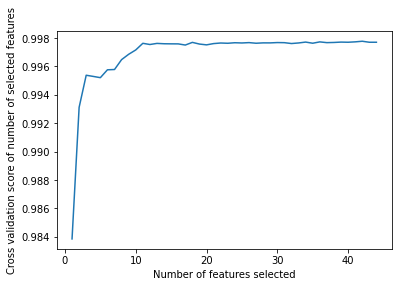

In [24]:

print('Optimal number of features :', rfecv.n_features_)
print('Best features :', train_pro.columns[rfecv.support_])

import matplotlib.pyplot as plt
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score of number of selected features")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

1. feature 39 (0.286640)
2. feature 16 (0.279414)
3. feature 5 (0.092451)
4. feature 17 (0.070969)
5. feature 18 (0.061573)
6. feature 40 (0.049963)
7. feature 41 (0.043742)
8. feature 29 (0.037308)
9. feature 24 (0.021070)
10. feature 9 (0.017317)
11. feature 43 (0.013420)
12. feature 8 (0.009481)
13. feature 34 (0.005770)
14. feature 42 (0.005313)
15. feature 19 (0.002195)
16. feature 10 (0.000358)
17. feature 28 (0.000288)
18. feature 25 (0.000268)
19. feature 35 (0.000209)


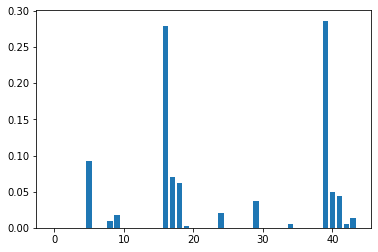

In [24]:
# decision tree for feature importance on a regression problem
model = ExtraTreesRegressor()
# fit the model
model.fit(train_pro, y_train)
# get importance
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
# Print the feature ranking
for f in range(df_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
# plot feature importance
plt.bar([x for x in range(len(importances))], importances)
plt.show()

In [25]:
train_pro.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5986 entries, 0 to 5985
Data columns (total 44 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Market_Category   5986 non-null   int64  
 1   Loyalty_customer  5986 non-null   int64  
 2   Product_Category  5986 non-null   int64  
 3   Grade             5986 non-null   int64  
 4   Demand            5986 non-null   int64  
 5   Discount_avail    5986 non-null   float64
 6   charges_1         5986 non-null   float64
 7   charges_2 (%)     5986 non-null   float64
 8   Minimum_price     5986 non-null   float64
 9   Maximum_price     5986 non-null   float64
 10  Year              5986 non-null   int64  
 11  Mon               5986 non-null   int64  
 12  date              5986 non-null   int64  
 13  day               5986 non-null   int64  
 14  hour              5986 non-null   int64  
 15  days_left         5986 non-null   float64
 16  avg               5986 non-null   float64


In [16]:
'Stall_no', 'instock_date', 'Market_Category', 'Customer_name',
       'Loyalty_customer', 'Product_Category', 'Grade', 'Demand', 'charges_1', 'charges_2 (%)', 
       , 'Year', 'Mon', 'date', 'day', 'hour',
       'days_left', 'unit_price1',
       'unit_price2', 'unit_price3', 'unit_price4', , 'crge1', 'crge2',
       'crge3', 'crge4', 'crge12', 'crge23', 'crge34', 'crge45',
       , 'crge112', 'crge222', 'crge322', 'crge422', 

Index(['Stall_no', 'instock_date', 'Market_Category', 'Customer_name',
       'Loyalty_customer', 'Product_Category', 'Grade', 'Demand',
       'Discount_avail', 'charges_1', 'charges_2 (%)', 'Minimum_price',
       'Maximum_price', 'Selling_Price', 'Year', 'Mon', 'date', 'day', 'hour',
       'days_left', 'avg', 'avg1', 'sell', 'unit_price', 'unit_price1',
       'unit_price2', 'unit_price3', 'unit_price4', 'crge', 'crge1', 'crge2',
       'crge3', 'crge4', 'crge11', 'crge12', 'crge23', 'crge34', 'crge45',
       'crge111', 'crge112', 'crge222', 'crge322', 'crge422', 'crge119',
       'crge129', 'crge239', 'crge349', 'crge459'],
      dtype='object')

In [ ]:
1. feature 39 (0.286640)
2. feature 16 (0.279414)
3. feature 5 (0.092451)
4. feature 17 (0.070969)
5. feature 18 (0.061573)
6. feature 40 (0.049963)
7. feature 41 (0.043742)
8. feature 29 (0.037308)
9. feature 24 (0.021070)
10. feature 9 (0.017317)
11. feature 43 (0.013420)
12. feature 8 (0.009481)
13. feature 34 (0.005770)
14. feature 42 (0.005313)
15. feature 19 (0.002195)

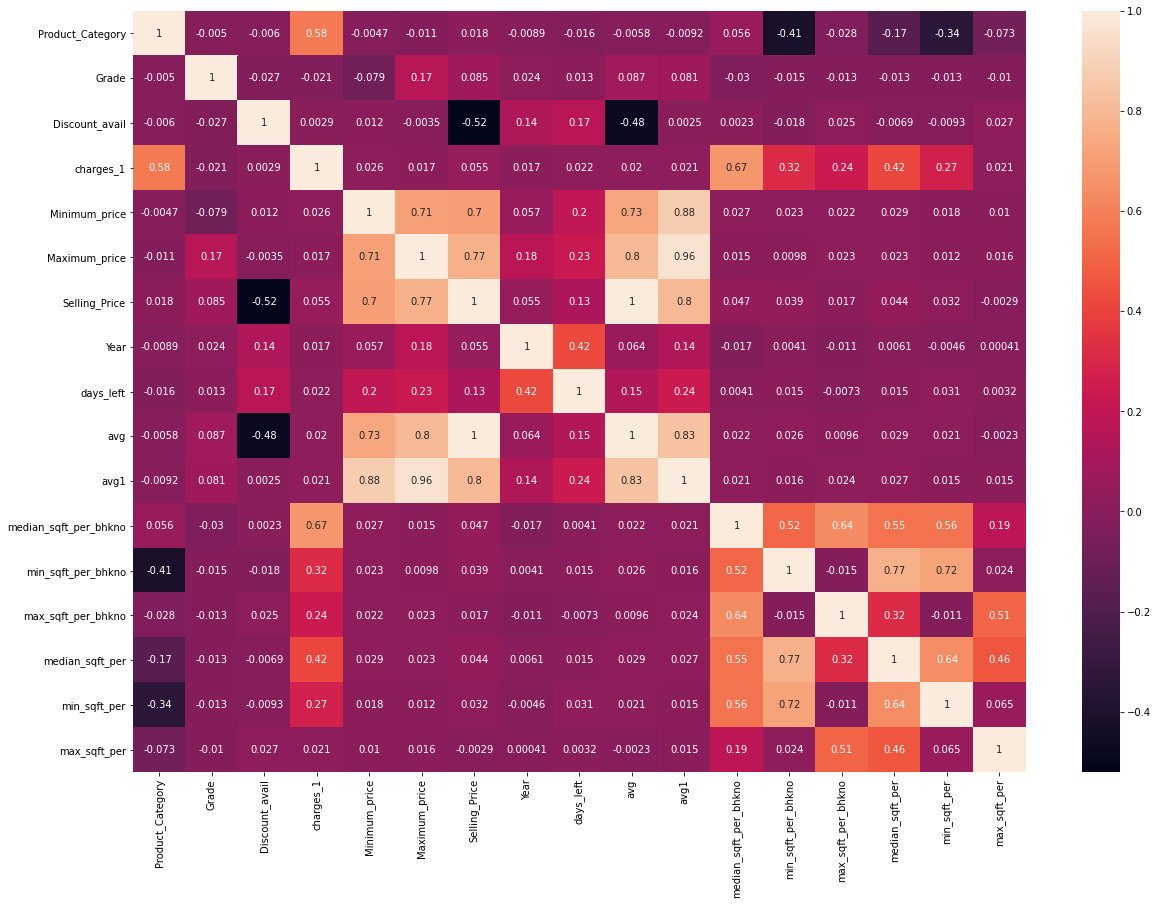

In [ ]:
plt.figure(figsize=(20, 14))
_ = sns.heatmap(train_proc.corr(), annot=True)

In [ ]:
df_train['Selling_Price'] = abs(df_train['Selling_Price'])


In [ ]:
df_train.isnull().sum()

Product_id            0
Stall_no              5
instock_date          0
Market_Category       0
Customer_name       211
Loyalty_customer      0
Product_Category      0
Grade                 0
Demand                0
Discount_avail       38
charges_1           198
charges_2 (%)       205
Minimum_price        38
Maximum_price       343
Selling_Price        41
dtype: int64

In [ ]:
df_train[df_train['Selling_Price']<0]

,Product_id,Stall_no,instock_date,Market_Category,Customer_name,Loyalty_customer,Product_Category,Grade,Demand,Discount_avail,charges_1,charges_2 (%),Minimum_price,Maximum_price,Selling_Price
50,WSCEFUV4TVWT73ZB,3.0,2014-11-01 09:46:30.000,0,Henry,Yes,Child_care,0,27,0.0,289.0,16.0,2368.0,4231.0,-3584.795550
952,BOTEGYTZ2T6WUJMM,22.0,2014-10-18 23:59:24.000,23,Benjamin,Yes,Pet_care,2,12,0.0,102.0,5.0,1390.0,5665.0,-3630.896874
1000,WATECHFU4QGFQEJG,15.0,2015-01-19 17:23:43.000,437,Audrey,No,Child_care,0,74,0.0,254.0,14.0,3885.0,5485.0,-4896.104400
1115,DREED6FKBQXMDWGM,14.0,2015-05-06 16:21:38.000,55,NaN,Yes,Pet_care,0,77,0.0,169.0,7.0,3829.0,6083.0,-5077.185300
1348,WATEAYZJBFJXB4FZ,44.0,2015-03-01 00:31:35.000,256,Tristan,Yes,Repair,0,22,0.0,285.0,2.0,2873.0,6511.0,-4965.495150
1674,SHOE3URGKNFYXDGP,46.0,2015-05-05 13:19:45.000,283,Steven,Yes,Pet_care,0,57,0.0,135.0,4.0,1975.0,2601.0,-2408.406912
2035,WSCEG2FYDYFDSVZ6,41.0,2014-10-29 12:46:30.000,236,Dylan,Yes,Hospitality,0,10,0.0,255.0,9.0,1320.0,7873.0,-4855.154436
2486,BELEG6KUK6ZBFTZJ,14.0,2014-11-09 20:15:45.000,437,Aubrey,Yes,Child_care,0,19,0.0,331.0,17.0,4044.0,5395.0,-5058.014148
3890,TOPDWSEVWXVQ4GXU,28.0,2015-05-06 14:20:59.000,1,Cesar,Yes,Cosmetics,0,1,0.0,208.0,16.0,2614.0,4891.0,-3966.103350
4188,RNGE7M92QK8FW7ZD,28.0,2015-08-16 23:12:20.000,14,Zaylee,No,Hospitality,0,23,1.0,325.0,9.0,4322.0,NaN,-822.810319


In [31]:
df_trai = df_train[df_train['Discount_avail']==0]
df_tra = df_train[df_train['Discount_avail']==1]

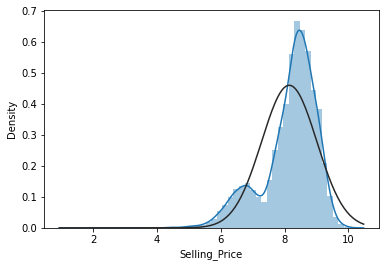

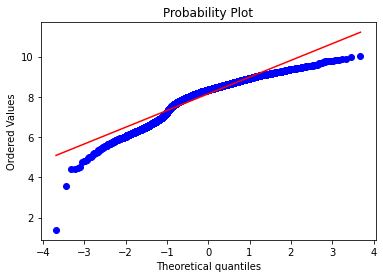

In [35]:
from scipy.stats import norm
from scipy import stats

#histogram and normal probability plot
sns.distplot(np.log(df_train['Selling_Price']), fit=norm);
fig = plt.figure()
res = stats.probplot(np.log(df_train['Selling_Price']), plot=plt)


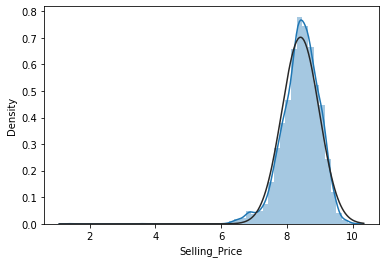

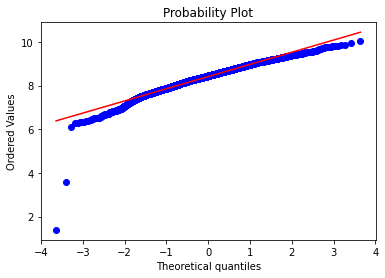

In [37]:
from scipy.stats import norm
from scipy import stats

#histogram and normal probability plot
sns.distplot(np.log(df_trai['Selling_Price']), fit=norm);
fig = plt.figure()
res = stats.probplot(np.log(df_trai['Selling_Price']), plot=plt)


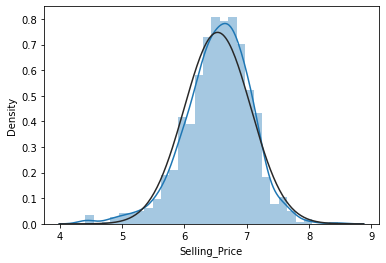

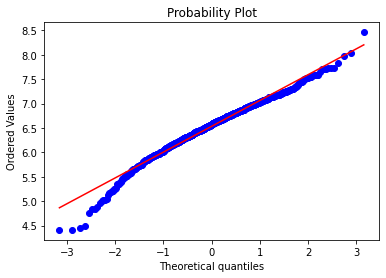

In [38]:
from scipy.stats import norm
from scipy import stats

#histogram and normal probability plot
sns.distplot(np.log(df_tra['Selling_Price']), fit=norm);
fig = plt.figure()
res = stats.probplot(np.log(df_tra['Selling_Price']), plot=plt)
